# Surface code

In [1]:
import import_ipynb
import TQEC_tools
import numpy as np
import stimcirq
import networkx as nx
from cirq.contrib.svg import SVGCircuit

importing Jupyter notebook from TQEC_tools.ipynb


In [2]:
# Each idling, two qubit and single qubit gates, measurement error rate
err = 1e-4
# Number of rounds for syndrome extract circuit
R = 3

# Set distance for the surface code
d = 3
# Number of data qubits in Surface code
Data = d**2
# Number of syndrome qubits in Surface code
Syn = Data - 1

# Physical qubit structures
Structure = np.arange( Data + Syn )
data_qubits = Structure[:d**2]
syn_qubits = Structure[d**2:]

In [3]:
# Calculate relative position of data qubits and syndrome qubits
def physical_qubit_pos( distance ):
    Data_qubit_structure = np.ones((distance,distance))
    
    # Data qubits on each vertex on the grid
    Data_pos = { }
    Data_positions = Data_qubit_structure.nonzero()
    for data_num in np.arange(distance**2):
        Data_pos[data_num] = ( Data_positions[0][data_num], Data_positions[1][data_num])
    
    # padding zero and put syndromes on (d+1)*(d+1) grid
    ## padding list
    ## body
    body = np.ones((distance-1,distance-1))
    body = np.pad(body, [(1, 1),(1,1)])
    
    ## top X
    top = [1 if i % 2 == 0
            else 0 for i in range(distance-1)]
    top = np.pad(top, (1, 1))
    
    ## bottom X
    bottom = [1 if i % 2 == 1
            else 0 for i in range(distance-1)]
    bottom = np.pad(bottom, (1, 1))
    
    ## left Z
    left = [[1] if i % 2 == 1
            else [0] for i in range(distance-1)]
    left = np.pad(left, [(1, 1),(0,0)])
    
    ## right Z
    right = [[1] if i % 2 == 0
            else [0] for i in range(distance-1)]
    right = np.pad(right, [(1, 1),(0,0)])

    body[0,:] = top
    body[:,0] = left[:,0]
    body[:,-1] = right[:,0]
    body[-1,:] = bottom

    X_syn = { }
    Z_syn = { }
    Syn_positions = body.nonzero()
    
    for syn_num in np.arange(distance**2 - 1):
        x = Syn_positions[0][syn_num]
        y = Syn_positions[1][syn_num]
        
        # separate X syndrome and Z syndrome
        if (x+y)%2 == 0:
            X_syn[syn_num + distance**2] = ( x-0.5, y-0.5)
        else:
            Z_syn[syn_num + distance**2] = ( x-0.5, y-0.5)   

    return Data_pos, X_syn, Z_syn

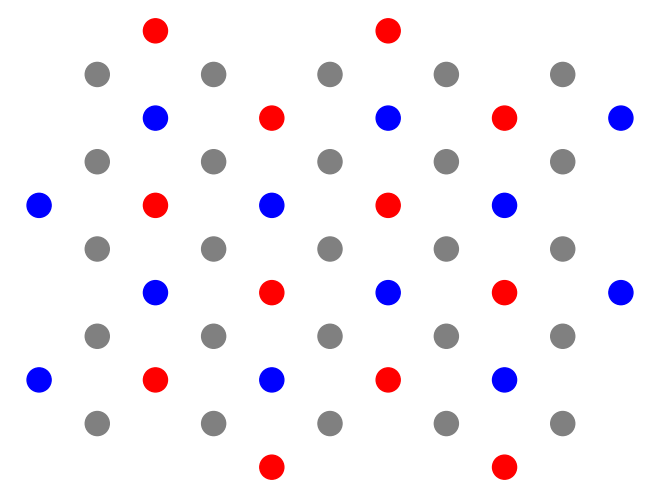

In [4]:
distance = 5
d,s_x,s_z = physical_qubit_pos( distance )

G = nx.Graph()
# Data qubits
for num,pos in d.items():
    G.add_node(num,pos=pos, color='grey')
# X syndrome qubits
for num,pos in s_x.items():
    G.add_node(num,pos=pos, color='red')
# Z syndrome qubits
for num,pos in s_z.items():
    G.add_node(num,pos=pos, color='blue')
    
pos=nx.get_node_attributes(G,'pos')
color = nx.get_node_attributes(G,'color').values()

nx.draw(G,pos=pos,node_color=color)

In [8]:
# Find pair qubits based on given active syndrome qubits and relative distance delta
def pair_qubits( qubits, delta ):
    global num2pos, pos2num
    
    # check if there is a relative qubit in our structure
    def delta_qubit( pos, delta ):
        try:
            return [ pos2num[pos], pos2num[(pos[0]+delta[0],pos[1]+delta[1])] ]
        except:
            pass
        
    active_pos = [ num2pos[num] for num in qubits ]
    relative_qubits = np.array([ delta_qubit(pos,delta) for pos in active_pos 
                                if delta_qubit(pos,delta) != None ])
    
    return relative_qubits[:,0], relative_qubits[:,1]

In [9]:
# Each idling, two qubit and single qubit gates, measurement error rate
err = 1e-4
# Number of rounds for syndrome extract circuit
R = 1

distance = 3
Data_dict, Syn_X_dict, Syn_Z_dict = physical_qubit_pos( distance )
Data = distance**2
Syn = Data - 1

# Physical qubit structures
Structure = np.arange( Data + Syn )
data_qubits = Structure[:Data]
syn_qubits = Structure[Data:]

num2pos = {**Data_dict, **Syn_X_dict, **Syn_Z_dict}
pos2num = {v: k for k, v in num2pos.items()}

# Create TQEC circuit
Surface_circuit = TQEC_tools.TQEC()
circuit = Surface_circuit.circuit

# Initialize physical qubits
Surface_circuit.physical_qubits(len(Structure))
Surface_circuit.bitflip_err(Structure,err)

################################################################
#########  Repeat syndrome extract circuit R rounds  ###########
################################################################

SynX_list = list(Syn_X_dict.keys())
SynZ_list = list(Syn_Z_dict.keys())

for _ in np.arange(R):
    
    # Syndrome extract circuit for step 0
    # Hadamard operator on X syndrome qubits
    Surface_circuit.single_gate("H",SynX_list)
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)
    
    # Syndrome extract circuit for step 1
    S_X_1_c, S_X_1_t = pair_qubits( SynX_list, (-0.5,0.5) )
    S_Z_1_t, S_Z_1_c = pair_qubits( SynZ_list, (-0.5,0.5) )
    control_qubits = np.concatenate((S_X_1_c, S_Z_1_c))
    target_qubits = np.concatenate((S_X_1_t, S_Z_1_t))
    
    Surface_circuit.cnot(control_qubits,target_qubits)
    # Depolarizing error for each cnot gate
    Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)

    # Syndrome extract circuit for step 2
    S_X_2_c, S_X_2_t = pair_qubits( SynX_list, (0.5,0.5) )
    S_Z_2_t, S_Z_2_c = pair_qubits( SynZ_list, (-0.5,-0.5) )
    control_qubits = np.concatenate((S_X_2_c, S_Z_2_c))
    target_qubits = np.concatenate((S_X_2_t, S_Z_2_t))
    
    Surface_circuit.cnot(control_qubits,target_qubits)
    # Depolarizing error for each cnot gate
    Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)

    # Syndrome extract circuit for step 3
    S_X_3_c, S_X_3_t = pair_qubits( SynX_list, (-0.5,-0.5) )
    S_Z_3_t, S_Z_3_c = pair_qubits( SynZ_list, (0.5,0.5) )
    control_qubits = np.concatenate((S_X_3_c, S_Z_3_c))
    target_qubits = np.concatenate((S_X_3_t, S_Z_3_t))
    
    Surface_circuit.cnot(control_qubits,target_qubits)
    # Depolarizing error for each cnot gate
    Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)
    
    # Syndrome extract circuit for step 4
    S_X_4_c, S_X_4_t = pair_qubits( SynX_list, (0.5,-0.5) )
    S_Z_4_t, S_Z_4_c = pair_qubits( SynZ_list, (0.5,-0.5) )
    control_qubits = np.concatenate((S_X_4_c, S_Z_4_c))
    target_qubits = np.concatenate((S_X_4_t, S_Z_4_t))
    
    Surface_circuit.cnot(control_qubits,target_qubits)
    # Depolarizing error for each cnot gate
    Surface_circuit.two_dep_err(control_qubits,target_qubits,err)
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)

    # Syndrome extract circuit for step 5
    # Hadamard operator on X syndrome qubits
    Surface_circuit.single_gate("H",SynX_list)
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)
    
    # Bit-flip errors before we measure syndrome qubits
    Surface_circuit.bitflip_err( SynX_list + SynZ_list, err )
    # Measure all syndrome qubits
    Surface_circuit.measure( syn_qubits )
    # Idling errors for deactivated qubits
    Surface_circuit.idling_err(err)

################################################################
################################################################
################################################################

# Measurement data qubits with bit-flip errors
Surface_circuit.bitflip_err( data_qubits, err )
Surface_circuit.measure( data_qubits )

# print( circuit )

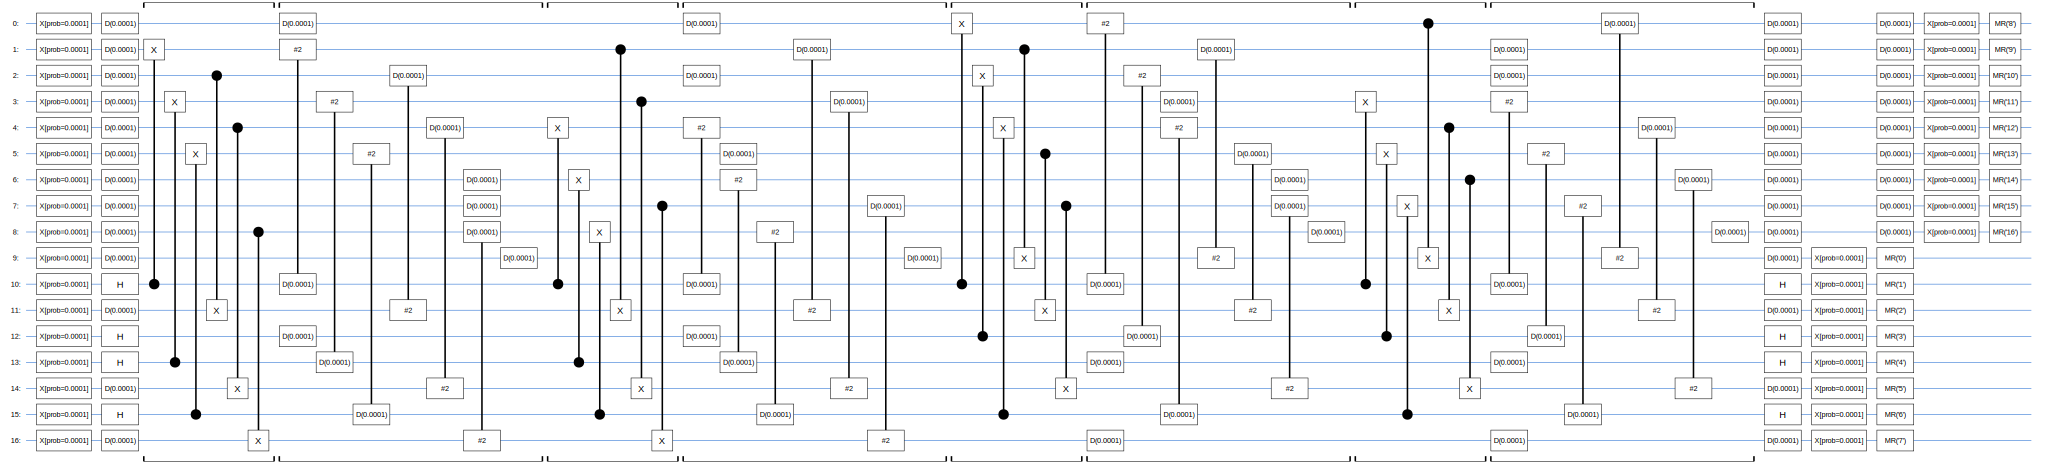

In [10]:
cirq_circuit = stimcirq.stim_circuit_to_cirq_circuit(circuit)
SVGCircuit(cirq_circuit)